#LibiumNet: Lip-Reading using RCNN

In [0]:

import os, glob
import imageio
import itertools
import math

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, TimeDistributed, LSTM, Input, CuDNNLSTM, BatchNormalization, Conv2D, MaxPooling2D, Reshape, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

imageio.plugins.ffmpeg.download()
tf.enable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4046848/45929032 bytes (8.8%)8224768/45929032 bytes (17.9%)12402688/45929032 bytes (27.0%)16531456/45929032 bytes (36.0%)20684800/45929032 bytes (45.0%)24764416/45929032 bytes (53.9%)28901376/45929032 bytes (62.9%)33095680/45929032 bytes (72.1%)37175296/45929032 bytes (80.9%)41336832/45929032 bytes (90.0%)45441024/45929032 bytes (98.9%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [0]:
tf.VERSION

'1.13.1'

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# mounting notebook to google drive
from google.colab import drive
drive.mount('/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive/


In [0]:

"""
This model generates generator of the datasets for the Network. 

@authors : Mustapha Tidoo Yussif, Samuel Atule, Jean Sabastien Dovonon
         and Nutifafa Amedior. 
"""
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNEL = 3
NUM_FRAMES = 29
NUM_CLASSES = 2
        
        
class GenerateDataset(object):
    """Generates generator for the datasets
    
    This model generates a generator for the datasets. This done to efficiently 
    manage space.
    
    :param: file_path: path to files/videos.
    :param directory: Path to the main directory.
    """
    def __init__(self, file_path, directory, n_items):
        self.n_items = n_items
        self.directory = directory
        self.file_path = file_path
        self.num_samples = len(self.samples(self.get_video_files(self.file_path, self.directory)))
        

    def load_video(self, filename):
        """Loads the specified video using ffmpeg.

        Returns:
            List[FloatTensor]: the frames of the video as a list of 3D tensors
                (channels, width, height)"""
        
        reader = imageio.get_reader(filename,  'ffmpeg')
        
        return np.array(list(reader), dtype=np.float32)
    
    def resize_frames(self, frames):
        """
        Crops the frames of the videos around the mouth region.
        This is the part that is most important part and relevant
        to the model (where we can get the relevant features)

        :param frames: The frames in the video. 
        :return: returns the croped frames.
        """
        tf.image.resize_images(X, (IMAGE_SIZE, IMAGE_SIZE), 
                                    tf.image.ResizeMethod.NEAREST_NEIGHBOR) 

    def get_sample_size(self):
      return self.num_samples
    
    
    def create_df(self, file_path):
        '''
        creates pandas dataframe of labels and words directories
        '''
        
        d = {}
        y_labels = []
        class_folders = []
        for ind, clss in enumerate(os.listdir(file_path)):
            y_labels.append(ind)
            class_folders.append(clss)
        
        d['directory'] = class_folders
        d['class'] = y_labels
        print(d)
        return pd.DataFrame(d)


    def get_video_files(self, file_path, directory=None):
        '''
        get video files from word class directories
        '''
        d = {}
        f = []
        
        for root, dirs, files in os.walk(file_path):
            if root.split('/')[-1] == directory:
                for file in files:
                    if file.endswith(".mp4"):
                        target_file = file.split('_')[0]
                        f.append(target_file)
                        if target_file not in d:
                            d[target_file] = []
                        d[target_file].append(os.path.join(root, file))
                    
        return d
        
    def generator(self, batch = 1):
        """Interfaces the private generator method

        :param num_items_per_class: The number of items in a categority. 
        :param batch: The batch size.
        """
        data = self.create_df(self.file_path)
        video_files = self.get_video_files(self.file_path, self.directory)
        return self._generator(data, directory = self.directory, video_files = video_files, BATCH_SIZE = batch)

    def samples(self, video_files):
      train = []
      for key, value in video_files.items():
        ind = 0
        for file in value:
          train.append(file)
          ind+=1
          if ind == self.n_items:
            break
          
      return train
    
    def _generator(self, data, directory=None, video_files=None, BATCH_SIZE = 64):
        
        '''
        retrieves the training batch for each iteration
        '''
        
        train = []
        for key, value in video_files.items():
            ind = 0
            for file in value:
                train.append(file)
                ind+=1
                if ind == self.n_items:
                  break
                
                  
                
        while True:
            # Randomize the indices to make an array
            indices_arr = np.random.permutation(len(train))
            
            for batch in range(0, len(indices_arr), BATCH_SIZE):
                # slice out the current batch according to batch-size
                current_batch = indices_arr[batch:(batch + BATCH_SIZE)]

                # initializing the arrays, x_train and y_train
                x_train = np.empty([0, NUM_FRAMES, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL], dtype=np.float32)
            
                y_train = np.empty([0], dtype=np.int32)

                for i in current_batch:
                    # get an image and its corresponding color for an traffic light
                    video_frames = self.load_video(train[i])
                    
                    
                    #preprocess frames from videos
#                     video_frames = tf.image.resize_nearest_neighbor(video_frames,(IMAGE_HEIGHT, IMAGE_WIDTH), )
                    #video_frames = tf.image.rgb_to_grayscale(video_frames)
#                     video_frames = tf.reshape(video_frames, (NUM_FRAMES, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))

                    # Appending them to existing batch
                    x_train = np.append(x_train, [video_frames/255], axis=0)
                    y_train = np.append(y_train, [ data.loc[ data['directory'] == train[i].split('/')[-1].split('_')[-2] ].values[0][1] ])
                    #print(data.loc[ data['directory'] == train[i].split('/')[-1].split('_')[-2] ].values[0][1])
                    
                
                y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

                yield(x_train, y_train)
        

In [0]:
gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'train', 2)
datasets = gen.generator()


{'directory': ['HOSPITAL', 'LEADER'], 'class': [0, 1]}


In [0]:
class LibiumNet(object):
    """TA lipreading model, `LibiunNet`
    This is lip reading model which reads or predicts the words of a spoken mouth in a silent video. 
    This model implements the RCNN (Recurrent Convolutional Neural Network) architecture. 

    :param img_c: The number of channels of the input image. i.e. a frame in a video (default 3).
    :param img_w: The width of the input image i.e. a frame in a video (default 256)
    :param img_h: The height of the input image i.e. a frame in a video (default 256)
    :param frames_n: The total number of frames in an input video (default 29)
    :param output_size: The output size of the network. 
    
    """
    def __init__(self, img_c=3, img_w=256, img_h=256, frames_n=29, output_size=10):
        self.img_c = img_c
        self.img_w = img_w
        self.img_h = img_h
        self.frames_n = frames_n
        self.output_size = output_size
        self.build()
    
    def build(self):
        """
        Retrieves the features from the last pool layer in the densenet pretrained model 
        and pass obtained features to LSTM network. 
        """
        input_shape = (self.frames_n, self.img_w, self.img_h, self.img_c) # input shape

        
        
        
        
        
        feature_extractor = Sequential()
        inputShape = (self.img_w, self.img_h, self.img_c)
        chanDim = -1
        
        feature_extractor.add(Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True), input_shape=inputShape))
        feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first CONV => RELU => CONV => RELU => POOL layer set
        
        feature_extractor.add(Conv2D(32, (3, 3)))
        feature_extractor.add(Activation("relu"))
        feature_extractor.add(BatchNormalization(axis=chanDim))
        feature_extractor.add(Conv2D(32, (3, 3)))
        feature_extractor.add(Activation("relu"))
        feature_extractor.add(BatchNormalization(axis=chanDim))
        feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))
        feature_extractor.add(Dropout(0.25))
        
        # second CONV => RELU => CONV => RELU => POOL layer set
        feature_extractor.add(Conv2D(64, (3, 3)))
        feature_extractor.add(Activation("relu"))
        feature_extractor.add(BatchNormalization(axis=chanDim))
        feature_extractor.add(Conv2D(64, (3, 3)))
        feature_extractor.add(Activation("relu"))
        feature_extractor.add(BatchNormalization(axis=chanDim))
        feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))
        feature_extractor.add(Dropout(0.25))
        
        
        TIME_PERIODS = self.frames_n
        dims = 53824

        model_m = Sequential()
        model_m.add(Conv1D(10, 2, activation='relu', input_shape=(TIME_PERIODS, dims)))
        model_m.add(Conv1D(10, 2, activation='relu'))
        #model_m.add(MaxPooling1D(3))
        #model_m.add(Conv1D(10, 3, activation='relu'))
        #model_m.add(Conv1D(10, 3, activation='relu'))
        #model_m.add(GlobalAveragePooling1D())
        #model_m.add(Dropout(0.5))
        
        
        self.input_data = Input(name='the_input', shape=input_shape, dtype='float32')
        self.image_frame_features = TimeDistributed(feature_extractor)(self.input_data) ## extracting the features from the images
        
        self.flat = TimeDistributed(Flatten())(self.image_frame_features) ## flatten before passing on to the recurrent network

        self.sequence1 = model_m(self.flat)
        self.sequence = CuDNNLSTM(16)(self.sequence1) 
        
        self.dense3 = Dense(10, activation='relu')(self.sequence)
        self.dense2 = Dense(10, activation='relu')(self.dense3)
        self.dense = Dense(self.output_size, name='logits')(self.dense2)

        self.pred = Activation('softmax', name='softmax')(self.dense)


        self.model = Model(inputs = self.input_data, outputs=self.pred)


    def summary(self):
        """"Summarizes the architecture of the model.
        
        :return: returns the model architecture summary
        """
        return self.model.summary()
      
    
    def train(self, generator,steps_per_epoch=None, epochs=1,validation_data=None, validation_steps=None, filepath="/gdrive/My Drive/LibiumNet/checkpoint.h5"):
        # Callbacks
        early_stopping_monitor = EarlyStopping(patience=3)
        checkpoint = ModelCheckpoint(
                            filepath, monitor='val_acc', verbose=1, 
                            save_best_only=True, mode='max'
                    )
        
        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', factor=0.2,
                              patience=7, min_lr=1e-9
                    )
        
        callbacks_list = [checkpoint, reduce_lr, early_stopping_monitor]

        
        print('Training...')
        
        self.model.compile(
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy']
        )
        
        history = self.model.fit_generator(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_data, validation_steps = validation_steps)
        
        #self.visualize_accuracy(history)
        self.visualize_loss(history)
      
      
    def predict(self, input_batch):
        """Predicts a video
        
        :param input_batch: A batch of a sequence of frames. 
        :return: returns the predicted probailities
        """
        return self.model(input_batch)
      
    def visualize_accuracy(self, history):
      """Visualize model accuracy
      """
      plt.plot(history.history['acc'], label='training accuracy')
      plt.plot(history.history['val_acc'], label='testing accuracy')
      plt.title('Accuracy')
      plt.xlabel('epochs')
      plt.ylabel('accuracy')
      plt.legend()
      
    def visualize_loss(self, history):
      """Visualizes model loss"""
      plt.plot(history.history['loss'], label='training loss')
      plt.plot(history.history['val_loss'], label='testing loss')
      plt.title('Loss')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.legend()

In [0]:
model = LibiumNet(output_size=2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 29, 256, 256, 3)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 29, 29, 29, 64)    65760     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 29, 53824)         0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 27, 10)            1076700   
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 16)                1792      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
__________

In [0]:
gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'train',100)
#gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'train')
datasets = gen.generator()
num_samples = gen.get_sample_size()
steps_per_epoch = math.ceil(num_samples / 2)

# validation
val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'val',20)
#val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'train')
val_datasets = val_gen.generator()
num_valid_samples = val_gen.get_sample_size()
steps_per_valid_epoch = math.ceil(num_valid_samples / 2)

num_samples

{'directory': ['HOSPITAL', 'LEADER'], 'class': [0, 1]}
{'directory': ['HOSPITAL', 'LEADER'], 'class': [0, 1]}


200

Training...
Epoch 1/25
100/100 [==============================] - 42s 421ms/step - loss: 0.6978 - acc: 0.5200 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 2/25
100/100 [==============================] - 39s 390ms/step - loss: 0.6941 - acc: 0.4300 - val_loss: 0.6915 - val_acc: 0.5500
Epoch 3/25
100/100 [==============================] - 39s 386ms/step - loss: 0.6937 - acc: 0.5600 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 4/25
100/100 [==============================] - 38s 384ms/step - loss: 0.6913 - acc: 0.5500 - val_loss: 0.6920 - val_acc: 0.5500
Epoch 5/25
100/100 [==============================] - 38s 383ms/step - loss: 0.6926 - acc: 0.5700 - val_loss: 0.6954 - val_acc: 0.4500
Epoch 6/25
100/100 [==============================] - 39s 386ms/step - loss: 0.6921 - acc: 0.5500 - val_loss: 0.6890 - val_acc: 0.6000
Epoch 7/25
100/100 [==============================] - 38s 379ms/step - loss: 0.6871 - acc: 0.6900 - val_loss: 0.6946 - val_acc: 0.4500
Epoch 8/25
100/100 [=======================

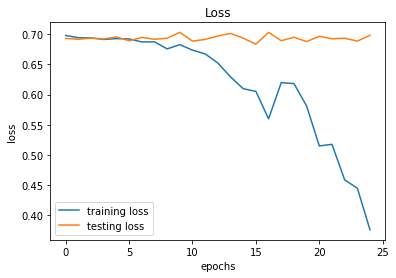

In [0]:
 # training 


model.train(datasets, steps_per_epoch = steps_per_epoch, epochs=25,validation_data=val_datasets, validation_steps=steps_per_valid_epoch)
#model.model.save('/gdrive/My Drive/LibiumNet/libium-500-60-L3.h5')

In [0]:
model.model.save('/gdrive/My Drive/LibiumNet/libium-100-20-LSTM2.h5')

RuntimeError: ignored

In [0]:
gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'train')
#gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'train')
datasets = gen.generator()
num_samples = gen.get_sample_size()

# validation
val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'val')
#val_gen = val_gen.generator()
#val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'test')
val_gen = val_gen.generator()

model.train(datasets, steps_per_epoch = steps_per_epoch, epochs=10,validation_data=val_gen, validation_steps=steps_per_epoch)
model.model.save('/gdrive/My Drive/LibiumNet/libium-0-4.h5')

In [0]:
gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'train')
#gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'train')
datasets = gen.generator()
num_samples = gen.get_sample_size()

# validation
val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'val')
#val_gen = val_gen.generator()
#val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'test')
val_gen = val_gen.generator()

model.train(datasets, steps_per_epoch = steps_per_epoch, epochs=10,validation_data=val_gen, validation_steps=steps_per_epoch)
model.model.save('/gdrive/My Drive/LibiumNet/libium-0-5.h5')

In [0]:
gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'train')
#gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'train')
datasets = gen.generator()
num_samples = gen.get_sample_size()

# validation
val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'val')
#val_gen = val_gen.generator()
#val_gen = GenerateDataset('/gdrive/My Drive/LibiumNet/overfit_test/', 'test')
val_gen = val_gen.generator()

model.train(datasets, steps_per_epoch = steps_per_epoch, epochs=10,validation_data=val_gen, validation_steps=steps_per_epoch)
model.model.save('/gdrive/My Drive/LibiumNet/libium-0-6.h5')

In [0]:
#model = LibiumNet(output_size=2)
gen = GenerateDataset('/gdrive/My Drive/LibiumNet/Lipread_mp4/', 'train')
datasets = gen.generator()
print(model.model.predict(next(datasets)))
print(model.model.predict(next(datasets)))
print(model.model.predict(next(datasets)))



{'directory': ['AFFAIRS', 'HOSPITAL', 'CHINA', 'LEADER', 'EDUCATION'], 'class': [0, 1, 2, 3, 4]}


IndexError: ignored

In [0]:
model.model.save('/gdrive/My Drive/LibiumNet/libium-0.2.h5')

In [0]:
 # print(list(os.listdir('/gdrive/My Drive/LibiumNet/lipread_mp4/')))
# print(next(datasets))

In [0]:
# def create_df(file_path):
#   '''
#   creates pandas dataframe of labels and words directories
#   '''
  
#   d = {}
#   y_labels = []
#   class_folders = []
#   for ind, clss in enumerate(os.listdir(file_path)):
#     y_labels.append(ind)
#     class_folders.append(clss)
  
#   d['directory'] = class_folders
#   d['class'] = y_labels
  
#   return pd.DataFrame(d)


# def get_video_files(file_path, directory=None):
#   '''
#   get video files from word class directories
#   '''
#   d = {}
#   f = []
  
#   for root, dirs, files in os.walk(file_path):
#     if root.split('/')[-1] == directory:
#       for file in files:
#         if file.endswith(".mp4"):
#           target_file = file.split('_')[0]
          
#           f.append(target_file)
            
            
#           if target_file not in d:
#             d[target_file] = []
#           d[target_file].append(os.path.join(root, file))
          
#   return d
      
  
  
  
# def load_video(filename):
#     """
#     Loads the specified video using ffmpeg.

#     Args:
#         filename (str): The path to the file to load.
#             Should be a format that ffmpeg can handle.

#     Returns:
#         List[FloatTensor]: the frames of the video as a list of 3D tensors
#             (channels, width, height)
#     """

#     reader = imageio.get_reader(filename,  'ffmpeg')
        
#     return np.array(list(reader), dtype=np.float32)

  
  
  
# def generator(data, directory=None, video_files=None, BATCH_SIZE=64):
  
#   '''
#   retrieves the training batch for each iteration
#   '''
#   IMAGE_HEIGHT = 256
#   IMAGE_WIDTH = 256
#   IMAGE_CHANNEL = 3
#   NUM_FRAMES = 29
#   NUM_CLASSES = 10
  
  
#   train = []
#   for key, value in video_files.items():
#     for file in value:
#       train.append(file)
  
#   while True:
#     # Randomize the indices to make an array
#     indices_arr = np.random.permutation(len(train))
    
#     for batch in range(0, len(indices_arr), BATCH_SIZE):
#       # slice out the current batch according to batch-size
#       current_batch = indices_arr[batch:(batch + BATCH_SIZE)]

#       # initializing the arrays, x_train and y_train
#       x_train = np.empty([0, NUM_FRAMES, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL], dtype=np.float32)
      
#       y_train = np.empty([0], dtype=np.int32)
#       for i in current_batch:
#           # get an image and its corresponding color for an traffic light
#           video_frames = load_video(train[i])

# #           Appending them to existing batch
#           x_train = np.append(x_train, [video_frames], axis=0)
#           y_train = np.append(y_train, [ data.loc[ data['directory'] == train[i].split('/')[-1].split('_')[-2] ].values[0][0] ])
          
#       y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

#       yield(x_train, y_train)
    
    

In [0]:
# video_files = get_video_files('/gdrive/My Drive/LibiumNet/lipread_mp4/', directory='train')
# data = create_df('/gdrive/My Drive/LibiumNet/lipread_mp4/')
    
# gen_obj = generator(data=data, directory='train', video_files=video_files)
# t_x, t_y = next(gen_obj)

# print(t_x)
# print(t_y)

In [0]:
# libium = LibiumNet(output_size=20)
# libium.predict(tensor)

In [0]:
# class GenerateDataset(object):
  
#     def __init__(self, dataset_path):
      
#         self.videos = os.listdir(dataset_path)
#         self.all_frames = []
        
#         for vid in self.videos:
#             frames = load_video(vid)
#             self.all_frames += frames

#     def gen(self):
#         for frame in self.all_frames:
#             yield(frame)

#     def get_dataset(self):
#         ds = tf.data.Dataset.from_generator(
#             self.gen, (tf.float32)
#         )
        
#         return ds
   
#     def get_input(path):
#       img = imread(path)
#       return(img)
    
    


In [0]:
class LibiumNet2(object):
    """TA lipreading model, `LibiunNet`
    This is lip reading model which reads or predicts the words of a spoken mouth in a silent video. 
    This model implements the RCNN (Recurrent Convulutional Neural Network) architecture. 

    :param img_c: The number of channels of the input image. i.e. a frame in a video (default 3).
    :param img_w: The width of the input image i.e. a frame in a video (default 256)
    :param img_h: The height of the input image i.e. a frame in a video (default 256)
    :param frames_n: The total number of frames in an input video (default 29)
    :param output_size: The output size of the network. 
    
    """
    def __init__(self, img_c=3, img_w=256, img_h=256, frames_n=29, output_size=10):
        self.img_c = img_c
        self.img_w = img_w
        self.img_h = img_h
        self.frames_n = frames_n
        self.output_size = output_size
        self.build()
    
    def build(self):
        """
        Retrieves the features from the last pool layer in the densenet pretrained model 
        and pass obtained features to LSTM network. 
        """
        input_shape = (self.frames_n, self.img_w, self.img_h, self.img_c) # input shape


        ## Getting the pre-trained image classifier, weights='imagenet'
        
        vgg = tf.keras.applications.nasnet.NASNetMobile(include_top=False, pooling='avg')
        
        #densenet = tf.keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet')
        #for layer in densenet.layers[:-50]:
        #    layer.trainable = False


        ######################
        ## BUILDING THE MODEL
        ######################
        self.input_data = Input(name='the_input', shape=input_shape, dtype='float32')
        self.image_frame_features = TimeDistributed(vgg)(self.input_data) ## extracting the features from the images

        #self.drop1 = Dropout(0.3)(self.image_frame_features)
        #self.flat = TimeDistributed(Flatten())(self.image_frame_features) ## flatten before passing on to the recurrent network
        self.flat = Flatten()(self.image_frame_features)
        
        #self.norm1 = BatchNormalization()(self.flat)
        
        #self.sequence1 = CuDNNLSTM(16, return_sequences = True)(self.flat) 
        #self.sequence = CuDNNLSTM(16)(self.flat) 
        
        #self.norm2 = BatchNormalization()(self.sequence)

        #self.drop2 = Dropout(0.1)(self.flat)
        
        #self.dense7 = Dense(4096, activation='relu')(self.sequence)
        #self.dense6 = Dense(1024, activation='relu')(self.dense7)
        #self.dense5 = Dense(256, activation='relu')(self.dense6)
        #self.dense4 = Dense(64, activation='relu')(self.dense5)
        self.dense3 = Dense(16, activation='relu')(self.flat)
        self.dense2 = Dense(4, activation='relu')(self.dense3)
        
#         
        #self.dense = Dense(self.output_size, name='dense1')(self.sequence)
        self.dense = Dense(self.output_size, name='logits')(self.dense2)

        self.pred = Activation('softmax', name='softmax')(self.dense)


        self.model = Model(inputs = self.input_data, outputs=self.pred)

    def summary(self):
        """"Summarizes the architecture of the model.
        
        :return: returns the model architecture summary
        """
        return self.model.summary()
      
    
    def train(self, generator,steps_per_epoch=None, epochs=1,validation_data=None, validation_steps=None, filepath="/gdrive/My Drive/LibiumNet/checkpoint.h5"):
        # Callbacks
        early_stopping_monitor = EarlyStopping(patience=3)
        checkpoint = ModelCheckpoint(
                            filepath, monitor='val_acc', verbose=1, 
                            save_best_only=True, mode='max'
                    )
        
        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', factor=0.2,
                              patience=7, min_lr=1e-80
                    )
        
        callbacks_list = [checkpoint, reduce_lr, early_stopping_monitor]

        
        print('Training...')
        
        self.model.compile(
              optimizer=tf.keras.optimizers.RMSprop(1e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy']
        )
        
        history = self.model.fit_generator(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_data, validation_steps = validation_steps)
        
        #self.visualize_accuracy(history)
        self.visualize_loss(history)
      
      
    def predict(self, input_batch):
        """Predicts a video
        
        :param input_batch: A batch of a sequence of frames. 
        :return: returns the predicted probailities
        """
        return self.model(input_batch)
      
    def visualize_accuracy(self, history):
      """Visualize model accuracy
      """
      plt.plot(history.history['acc'], label='training accuracy')
      plt.plot(history.history['val_acc'], label='testing accuracy')
      plt.title('Accuracy')
      plt.xlabel('epochs')
      plt.ylabel('accuracy')
      plt.legend()
      
    def visualize_loss(self, history):
      """Visualizes model loss"""
      plt.plot(history.history['loss'], label='training loss')
      plt.plot(history.history['val_loss'], label='testing loss')
      plt.title('Loss')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.legend()